# KNN


In [1]:
from sklearn.model_selection import train_test_split

from assignment_2.digits_classifiers.model import Dataset, ClassifierTuning
from assignment_2.digits_classifiers.classifiers import KNN
from assignment_2.digits_classifiers.io import read_datasets

## Import dataset

In [2]:
data = read_datasets()

2022-12-22 11:12:12.680 | INFO     | assignment_2.digits_classifiers.io:read_datasets:46 - Reading datasets


In [3]:
X, y = data

## Discard part of data

In [4]:
X, _, y, _ = train_test_split(X, y, test_size=0.95)

## Removing constant columns

In [5]:
X.shape

(3500, 784)

In [6]:
always_zero = [c for c in list(X.columns) if sum(X.loc[:, c]) == 0]
len(always_zero)

140

In [7]:
X.drop(columns=always_zero, axis=1, inplace=True)
X.shape

C:\Users\user\AppData\Local\Temp/ipykernel_21592/2881930721.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=always_zero, axis=1, inplace=True)


(3500, 644)

## Train Test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

In [9]:
X_train

,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,...,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel778,pixel779,pixel780
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
data = Dataset(x=X, y=y)
train = Dataset(x=X_train, y=y_train)
test = Dataset(x=X_test, y=y_test)

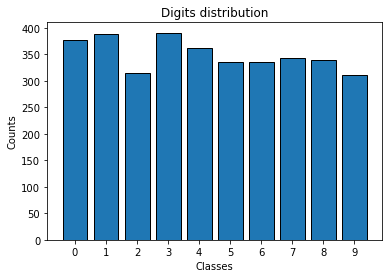

In [11]:
data.digit_distribution()

## Training KNN

In [12]:
knns = [
    KNN(train=train, test=test, params={"k": k})
    for k in [5, 10, 30, 50]
]

Using small dimensionality for validation_train

In [13]:
_, X_train_cv, _, y_train_cv = train_test_split(X_train, y_train, test_size=0.33)
train_cv = Dataset(x=X_train_cv, y=y_train_cv)

In [14]:
X_train_cv

,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,...,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel778,pixel779,pixel780
1307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2416,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2758,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
tuning_knns = ClassifierTuning(classifiers=knns, base_estimator=KNN.default_estimator(), data=train, k=5)
tuning_knns

[Estimator: KNNEstimator(); K: 5; Params: {'k': [10, 50, 5, 30]}]

In [16]:
%%time
tuning_knns.evaluate()

Wall time: 2min 7s


In [17]:
tuning_knns.best_params

{'k': 5}

In [18]:
tuning_knns.best_score

0.9146428571428572

In [19]:
best_knn = KNN(train=train, test=test, params=tuning_knns.best_params)
best_knn

[KNN: Train 2800, Test 700, not fitted, not predicted] [k: 5]

In [20]:
%%time
best_knn.train()

Wall time: 0 ns


In [21]:
%%time
best_knn.predict()

Wall time: 19.3 s


In [22]:
best_knn.accuracy

0.9371428571428572

2022-12-22 11:14:46.058 | INFO     | assignment_2.digits_classifiers.model:confusion_matrix:197 - Saving C:\Users\user\Documents\GitHub\AI_assignments\assignment_2\digits_classifiers\images\knn_cm.png


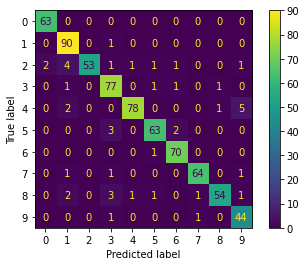

In [23]:
best_knn.confusion_matrix(save=True, file_name='knn_cm.png')

### Fool data

In [25]:
from assignment_2.digits_classifiers.io import read_fool_dataset

X_fool = read_fool_dataset()
X_fool.drop(columns=always_zero, axis=1, inplace=True)

In [26]:
best_knn.estimator.predict(X=X_fool)

array([9., 4., 0., 4., 5., 1.])